In [1]:
import matplotlib.pyplot as plt
%matplotlib inline 
import numpy as np
from scipy.signal import find_peaks
from skimage.transform import rotate
import pims, sys
from pathlib import Path
from scipy.signal import savgol_filter
sys.path.insert(0, 'C:\\Warwick\\Code\\')
from Image_Analysis.Filament_Analysis.geometric_2 import SimpleSpline
from skimage.filters import threshold_yen

<blockquote>1. Load the image series, the filament axis (or axes) and visualise.</blockquote>

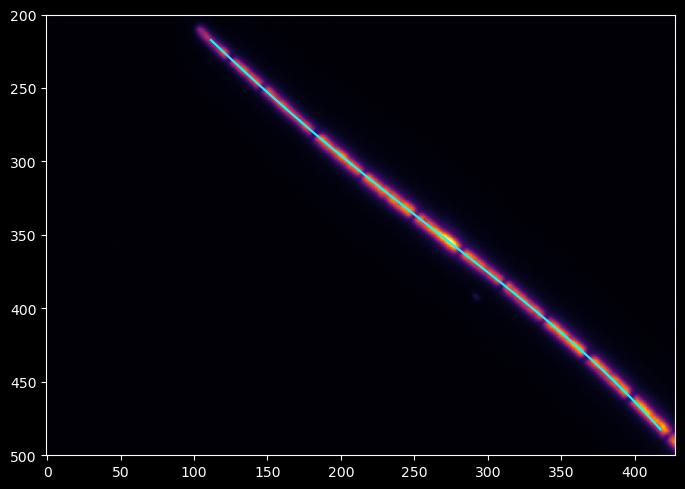

In [4]:
base_path = Path(r'C:\Users\jrosk\Dropbox\Warwick\TIRF\February_2023\21-02-2023\Untreated_Sample')

file_path_0 = base_path.joinpath(r'Slides\Slide_1\21-Feb-23_TIRF473-3.tif')


axis_path_0 = Path('splines\spline_0.txt')

axis_0 = SimpleSpline.from_csv(axis_path_0, 0.01)

# This is to crop the stack, so that we only have the red channel
@pims.pipeline
def red_channel(frame):
    return frame[:,428:]

@pims.pipeline
def green_channel(frame):
    return frame[:,:428]

both_channels = pims.open(file_path_0.as_posix())

# Apply pipeline
images_red = red_channel(both_channels)
images_green = green_channel(both_channels)

#Sometimes the spline goes beyond the image dimensions and causes issues
axis_0.crop_to_image_dimensions(images_red[0].shape)


# Visualise the spline
with plt.style.context('dark_background'):
    fig , ax = plt.subplots(1,1, figsize=(8,5))

    ax.imshow(images_red[400], cmap='inferno')
    ax.plot(axis_0.xy[500:-1000,0], axis_0.xy[500:-1000:,1], color='cyan')
    ax.set_ylim(500,200)
    plt.tight_layout()
    plt.show()

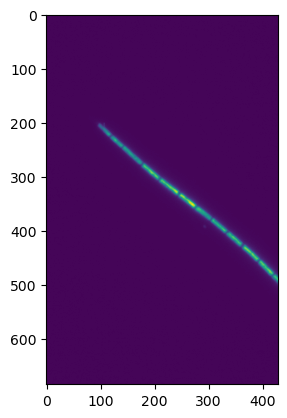

In [7]:
from Image_Analysis.Filament_Analysis.various_funcs import spline_erase
# Creating the main mask
spline_top = axis_0.shift_spline(-5)
spline_bottom = axis_0.shift_spline(5)

erased_top = spline_erase(spline_top,images_red[700], mode='over', cursor=['right', 420]) # 500 for red ch
erased_bot = spline_erase(spline_bottom, erased_top, mode='under', cursor = ['left', 105])

for n in range(200,0,-1):
    erased_bot[n,:] = 0

primary_image_mask = erased_bot > 0

plt.imshow(500*primary_image_mask + images_red[700])

In [8]:
import pandas as pd
from pathlib import Path

septae_path = Path(r'C:\Warwick\Code\Image_Analysis\Jupyter-Notebooks\Filament_Axes\22-02-2023\Analysis\linked_septae_03_09_2023.csv')
septae = pd.read_csv(septae_path, low_memory=False)
septae = septae[septae['experiment'] == file_path_0.stem]

In [10]:
septae.head()

frame       x    params    distance  particle full_cell  \
57892      0  410.68  0.395435   25.277343         1      True   
57893      0  381.49  0.667403   66.901061         2      True   
57894      0  354.16  0.651842  103.960438         3      True   
57895      0  325.44  0.769755  141.600468         4      True   
57896      0  297.30  0.476857  177.715845         5      True   

                experiment  
57892  21-Feb-23_TIRF473-3  
57893  21-Feb-23_TIRF473-3  
57894  21-Feb-23_TIRF473-3  
57895  21-Feb-23_TIRF473-3  
57896  21-Feb-23_TIRF473-3

In [11]:
ordered_septae = septae.loc[septae['frame']==0, ['particle']].values.ravel()
initial_septae_pairs = [[ordered_septae[n-1],ordered_septae[n]] for n in range(1, len(ordered_septae))]

# I want a frame: pairs_present dictionary
pairs_in_frame = {}
for frame in pd.unique(septae['frame']):
    septae_in_frame = septae.loc[septae['frame']==frame, ['particle']].values.ravel()
    possible_septae_pairs = [[septae_in_frame[n-1],septae_in_frame[n]] for n in range(1, len(septae_in_frame))]
    
    filtered_septae_pairs = []
    for pair in possible_septae_pairs:
        if pair in possible_septae_pairs or pair[::-1] in possible_septae_pairs:
            filtered_septae_pairs.append(pair)
    
    if len(filtered_septae_pairs) > 1:
        pairs_in_frame[frame] = filtered_septae_pairs

In [14]:
from skimage.registration import optical_flow_tvl1,optical_flow_ilk

output_list = []
frame_step = 3

def calculate_optic_flow(img_1, img_2, filament_axis, x_current):
    
    u, v = optical_flow_tvl1(img_1, img_2)
    u_avg = np.average(u)
    v_avg = np.average(v)

    # Middle index in current cell and corresponding normal slope
    middle_x = x_current[0] + (x_current[1] - x_current[0])/2
    normal_slope = septum_normal_coeffs(middle_x, filament_axis)[0].item()

    # orthogonal flow
    perpendicular_vector = np.array([1, normal_slope]).reshape(2,)
    perpendicular_vector /= np.linalg.norm(perpendicular_vector)

    #tangential flow
    tangent_slope = filament_axis.derivative_func(middle_x)
    tangent_vector = np.array([1, tangent_slope]).reshape(2,)
    tangent_vector /= np.linalg.norm(tangent_vector)

    average_flow_vector = np.array([u_avg, v_avg]).reshape(2,)
    ortho_flow = np.dot(perpendicular_vector, average_flow_vector)
    tan_flow = np.dot(tangent_vector, average_flow_vector)

    return middle_x, tan_flow, ortho_flow


def single_cell_mask(masked_image, coeffs):
    x_segment= np.arange(0, masked_image.shape[1] -1, 0.25)
    y_left = coeffs[0][0]*x_segment + coeffs[1][0]
    y_right = coeffs[0][1]*x_segment + coeffs[1][1]
    erased_left = spline_erase(np.column_stack((x_segment, y_left)),masked_image, mode='left')
    erased_right = spline_erase(np.column_stack((x_segment, y_right)),erased_left, mode='right')
    return erased_right

def septum_normal_coeffs(x_values, filament_axis):
    xy = np.column_stack((x_values, filament_axis.spline_object(x_values)))
    dydx = np.column_stack((x_values, filament_axis.derivative_func(x_values)))
    return filament_axis.normal_line_coeffs(custom_xy=xy, custom_dydx=dydx)


all_frames = list(pairs_in_frame.keys())[::frame_step]

# all_frames, septae, primary_image_mask, filament_axis, images_0, images_1

for n in range(1,len(all_frames)): # len(all_frames)
    if n%100 == 0:
        print(f'{n/len(all_frames)} % of the way done.')
    
    pairs_in_both = [pair for pair in pairs_in_frame[all_frames[n-1]] if pair in pairs_in_frame[all_frames[n]]]

    for pair in pairs_in_both:

        x_current = septae.loc[(septae['frame']==all_frames[n-1]) & septae['particle'].isin(pair)]['x'].tolist()
        x_current.sort()

        x_next = septae.loc[(septae['frame']==all_frames[n]) & septae['particle'].isin(pair)]['x'].tolist()
        x_next.sort()
        
        cell_mask_current = single_cell_mask(primary_image_mask, 
                                             septum_normal_coeffs(x_current, axis_0))
        
        cell_mask_next = single_cell_mask(primary_image_mask, 
                                          septum_normal_coeffs(x_next, axis_0))


        cell_current, cell_next = images_red[all_frames[n]-1], images_red[all_frames[n]]

 
        # masked_image = np.where(mask, image, 0)
        cell_current = np.where(cell_mask_current, cell_current, 0)
        cell_next = np.where(cell_mask_next, cell_next, 0)

        # flow
        middle_x, tan_flow, ortho_flow = calculate_optic_flow(cell_current, cell_next, axis_0, x_current)
        output_row = [all_frames[n], pair, x_current, middle_x, tan_flow, ortho_flow]
        output_list.append(output_row)
        


0.16420361247947454 % of the way done.
0.3284072249589491 % of the way done.
0.49261083743842365 % of the way done.
0.6568144499178982 % of the way done.
0.8210180623973727 % of the way done.
0.9852216748768473 % of the way done.


In [15]:
flow_dataframe = pd.DataFrame(output_list, columns=['frame', 'pair_id', 'x_low','x_mid', 'tan_flow' ,'ortho_flow'])
flow_dataframe['pair_str_id'] = flow_dataframe['pair_id'].apply(lambda x: "_".join(map(str, sorted(x))))
flow_dataframe.head()

frame  pair_id                                     x_low    x_mid  \
0      6   [4, 3]   [325.13000000011186, 353.9500000001266]  339.540   
1      6   [3, 2]    [353.9500000001266, 381.4000000001406]  367.675   
2      6   [2, 1]   [381.4000000001406, 410.38000000015546]  395.890   
3      6  [10, 9]  [138.98000000001662, 161.46000000002812]  150.220   
4      9   [2, 1]    [381.3300000001406, 410.3500000001554]  395.840   

   tan_flow  ortho_flow pair_str_id  
0 -0.007576   -0.000001         3_4  
1 -0.008518    0.000111         2_3  
2 -0.003763   -0.000667         1_2  
3  0.013199   -0.002252        9_10  
4 -0.007820   -0.002949         1_2

In [16]:
flow_dataframe.to_csv(r'optic_flow_factor_3_tvl1_5pxROI_Ch_red.csv')

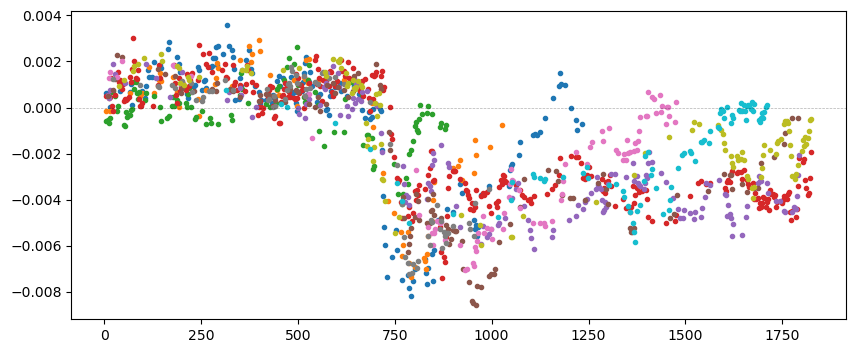

In [17]:
fig, ax = plt.subplots(1,1, figsize=(10,4))
for str_id in pd.unique(flow_dataframe['pair_str_id']):
    data = flow_dataframe.loc[flow_dataframe['pair_str_id'] == str_id]
    if len(data['frame'].values) > 60:
        plt.plot(data['frame'].values, np.convolve(data['ortho_flow'].values,[1,1,1,1,1], mode='same')/5, '.')
ax.axhline(0, linestyle='--', linewidth=0.5, color='black', alpha=0.3)
#plt.ylim(-0.1,0.15)
#plt.xlim(0,750)